<h1><strong><u>K-Nearest Neighbors Model</u></strong></h1>

<h2><strong><u>Data Preparation</u></strong></h2>

In [2]:
%%capture
%run DataPreparation.ipynb

<h2><strong><u>KNN Model Selection</u></strong></h2>

<h3><strong><u>Validation Curves</u></strong></h3>

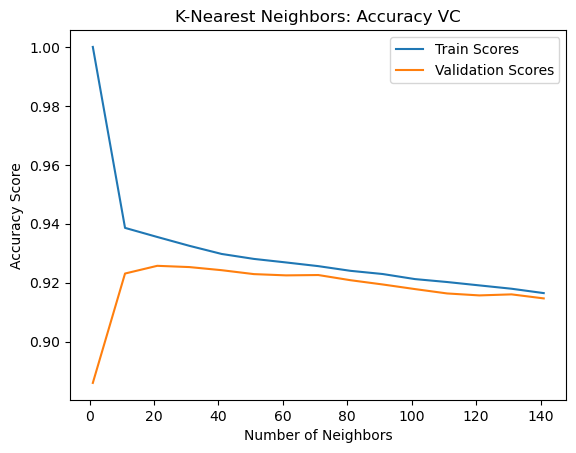

In [11]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)
neighbors = list(range(1, 151, 10))
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__n_neighbors",
                                                   param_range=neighbors,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.ylabel("Accuracy Score")
plt.xlabel("Number of Neighbors")
plt.title("K-Nearest Neighbors: Accuracy VC")
plt.plot(neighbors, train_scores_mean, label="Train Scores")
plt.plot(neighbors, validation_scores_mean, label="Validation Scores")
plt.legend()

<h3><strong><u>Cross Validation Testing</u></strong></h3>

In [3]:
pipeline = Pipeline(
    [
        ("vect", TfidfVectorizer(tokenizer=custom_tokenizer, token_pattern=None)),
        ("clf", KNeighborsClassifier())
    ]
)
param_grid = {
    "clf__n_neighbors": [23, 25, 27, 29],
}

model = GridSearchCV(pipeline, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
model.fit(X_train, y_train)
knn_classifier = model.best_estimator_
model.best_params_

def knn_model():
    return knn_classifier

<h4><strong><u>Findings From 'Model Selection' Section</u></strong></h4>
The scoring metrics that I used for the Grid Search cross-validation test was accuracy since the dataset is balanced. I chose to validate for a wide range of neighbors so that I could see the overall test/validation score trend with the increase of neighbors. It was pretty clear to see that somewhere between 20-25 is the best neighbor count. The Grid Search cross-validation resulted in a neighbor count of 23 for the model.

<h2><strong><u>Model Evaluation</u></strong></h2>

<h3><strong><u>Learning Curves</u></strong></h3>

In [ ]:
for key, value in clf_metrics.items():
    knn_train_sizes, knn_train_scores, knn_validation_scores = learning_curve(
        knn_classifier,
        X_train,
        y_train,
        cv=5,  # Number of folds for cross-validation
        scoring=value,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    knn_train_scores_mean = np.mean(knn_train_scores, axis=1)
    knn_train_scores_std = np.std(knn_train_scores, axis=1)
    knn_validation_scores_mean = np.mean(knn_validation_scores, axis=1)
    knn_validation_scores_std = np.std(knn_validation_scores, axis=1)

    # Calculate spread of data around the mean
    knn_train_range_minus = knn_train_scores_mean - knn_train_scores_std
    knn_train_range_plus = knn_train_scores_mean + knn_train_scores_std
    knn_validation_range_minus = knn_validation_scores_mean - knn_validation_scores_std
    knn_validation_range_plus = knn_validation_scores_mean + knn_validation_scores_std

    lc_dict[key] = [[knn_train_scores_mean, knn_validation_scores_mean],
                    [knn_train_range_minus, knn_train_range_plus], 
                    [knn_validation_range_minus, knn_validation_range_plus], 
                    knn_train_sizes]

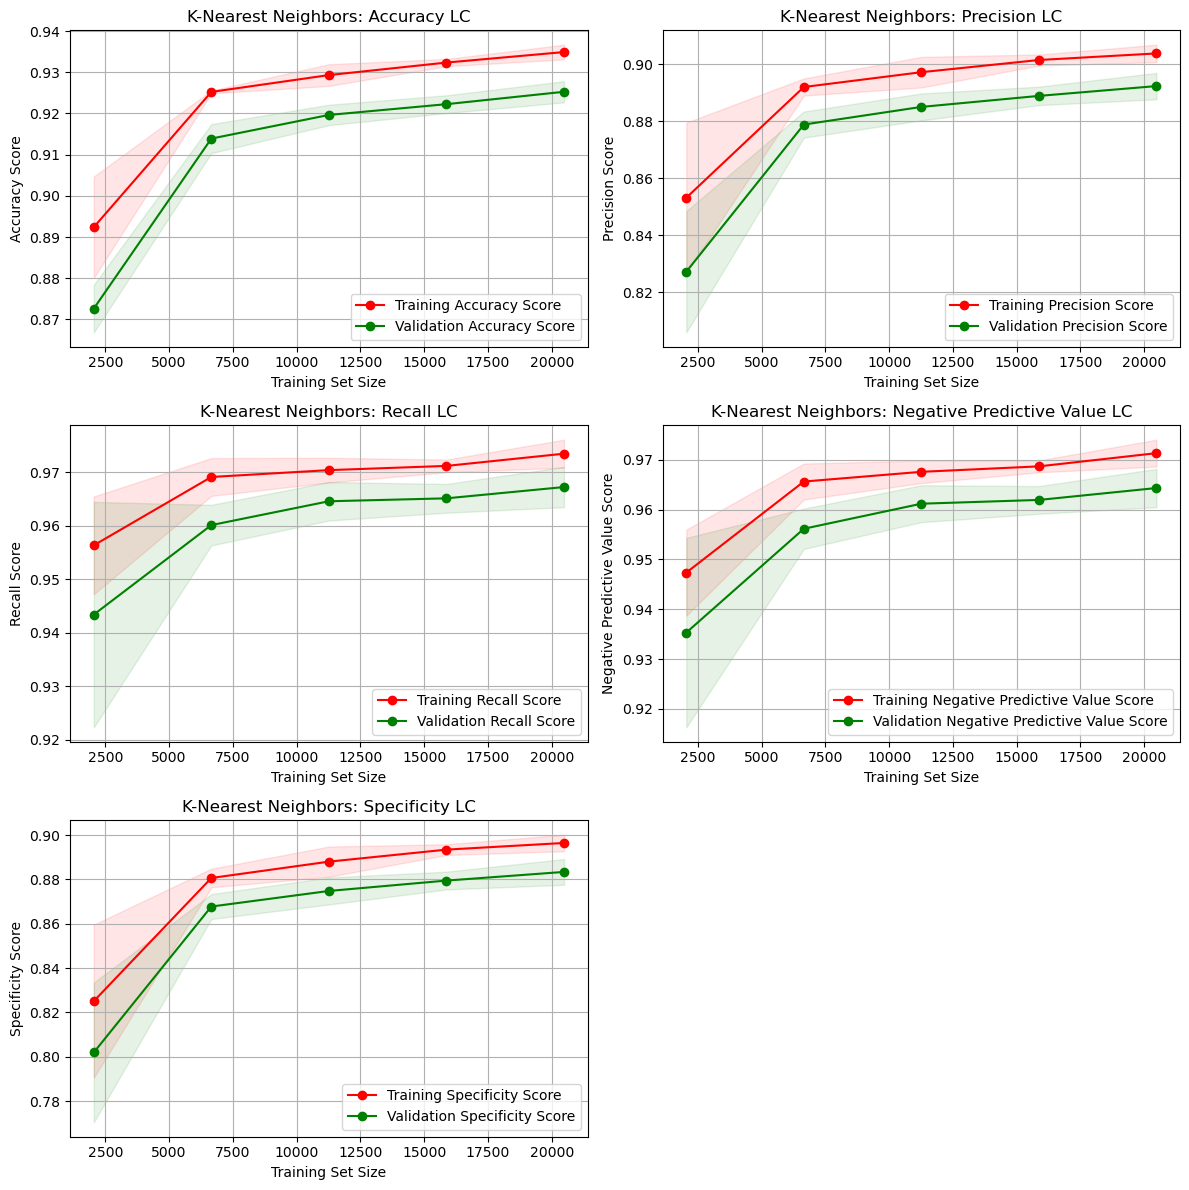

In [11]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))

# Flatten the axes array for easier iteration
axs = axs.flatten()
count = 0
for key, value in lc_dict.items():
    axs[count].set_title(f"K-Nearest Neighbors: {key} LC")
    axs[count].set_xlabel("Training Set Size")
    axs[count].set_ylabel(f"{key} Score")
    axs[count].grid()

    axs[count].fill_between(value[3], value[1][0], value[1][1], alpha=0.1, color="r")
    axs[count].fill_between(value[3], value[2][0], value[2][1], alpha=0.1, color="g")
    axs[count].plot(value[3], value[0][0], 'o-', color="r", label=f"Training {key} Score")
    axs[count].plot(value[3], value[0][1], 'o-', color="g", label=f"Validation {key} Score")
    axs[count].legend(loc="best")
    count += 1
    
fig.delaxes(axs[count]) 

plt.tight_layout()
plt.show()

<h3><strong><u>Evaluation Metrics</u></strong></h3>

In [9]:
for key, value in clf_metrics.items():
    print(f"{key}")
    nb_training_values = cross_val_score(knn_classifier, X_train, y=y_train, scoring=value, cv=5)
    print("CV Training Scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(f"Training Average and Standard Error: ", "{:.2f}%".format(average.round(2)), "\u00B1", "{:.2f}%".format(stDev.round(4)*100), "\n")

Accuracy
CV Training Scores:  [0.9234375  0.92753906 0.92382812 0.92246094 0.92910156]
Training Average and Standard Error:  0.93% ± 0.26% 

Precision
CV Training Scores:  [0.88904847 0.89179506 0.89389535 0.88658318 0.90010937]
Training Average and Standard Error:  0.89% ± 0.46% 

Recall
CV Training Scores:  [0.96756546 0.9730258  0.96168882 0.96872557 0.96520719]
Training Average and Standard Error:  0.97% ± 0.38% 

Negative Predictive Value
CV Training Scores:  [0.96445396 0.97037355 0.95861486 0.9655914  0.96255785]
Training Average and Standard Error:  0.96% ± 0.38% 

Specificity
CV Training Scores:  [0.87934401 0.88212334 0.88602654 0.87626854 0.8930523 ]
Training Average and Standard Error:  0.88% ± 0.58% 



Text(0.5, 1.0, 'K-Nearest Neighbors: Confusion Matrix (Evaluation)')

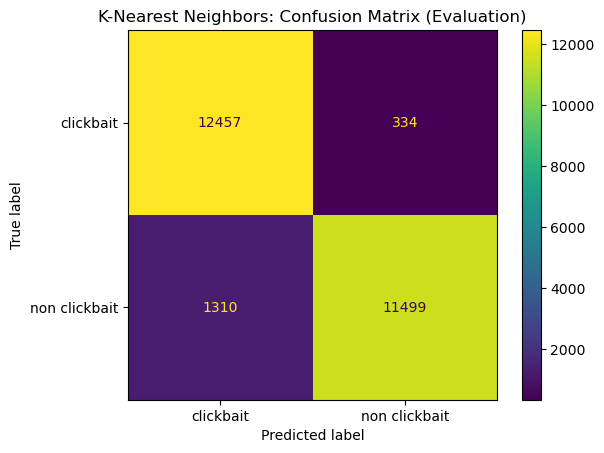

In [6]:
#Training Confusion Matrix
disp = ConfusionMatrixDisplay.from_estimator(knn_classifier, X_train, y_train, labels=['clickbait', 'non clickbait'])
disp.ax_.set_title("K-Nearest Neighbors: Confusion Matrix (Evaluation)")

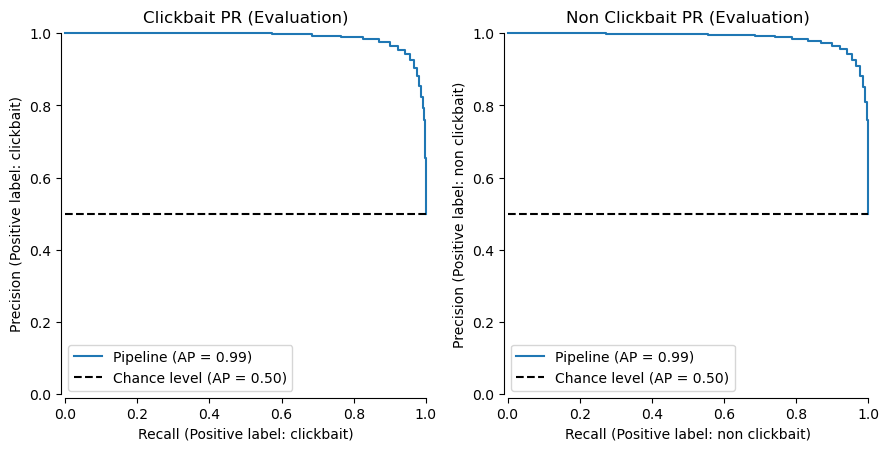

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(9, 9))
axs = axs.flatten()
count = 0
for label in train_labels:
    disp = PrecisionRecallDisplay.from_estimator(knn_classifier, X_train, y_train, ax=axs[count], pos_label=label, plot_chance_level=True, despine=True)
    disp.ax_.set_title(f"{label.title()} PR (Evaluation)")
    count += 1

plt.tight_layout()  
plt.show()

<h4><strong><u>Findings From 'Model Evaluation' Phase</u></strong></h4>
In the evaluation of my selected model, I found positive results for all evaluation methods. The learning curves yielded good results and the 'cross_val_score' function evaluation results reinforced the learning curve values. In addition, the Confusion Matrix helps show that the model performed well on the training data with minimal False Negatives and False Positives. Finally, The Precision-Recall plots display a good curves that moves to the top-right corner of the plot indicating a good classifier model. As a result, I will move forward with this model to the 'Model Testing' section.

<h2><strong><u>Conclusion</u></strong></h2>
Considering the results of the experiment, I believe this model can used for clickbait classification.